# Use CUST_SEGMT_Template Customized Notebook Template

In [1]:
# import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans,AgglomerativeClustering,DBSCAN,SpectralClustering
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_samples, silhouette_score

Matplotlib created a temporary cache directory at /tmp/matplotlib-4o2g23ym because the default path (/home/mosaic-ai/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


# Read data from Snowflake CUSTOMER_TRANSACTION_MASTER using fosforio sdk

In [2]:
from fosforml.model_manager.snowflakesession import get_session
my_session = get_session()

Connection manager service url initialised to http://fdc-project-manager:80/project-manager
If you need to update its value then update the variable CONNECTION_MANAGER_BASE_URL in os env.


In [3]:
table_name = 'CUSTOMER_TRANSACTION_MASTER'

sf_df = my_session.sql("select * from {}".format(table_name))
df = sf_df.to_pandas()

Exception occurred in getting snowflake connection: 'connectionSources'


In [5]:
df_original = df.copy()

In [6]:
df.shape

(122882, 27)

In [7]:
df.tail()

,CUSTOMER_ID,DATE,AGE,SEX,EDUCATION_LEVEL,EMPLOYMENT_STATUS,HOBBIES,MARITAL_STATUS,DEPENDENTS,REGISTRATION_DATE,...,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,PURCHASES_TRX,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT
122877,3a7ce3d5-0f4b-4575-badc-3553f5440c92,2023-05-01,32,MALE,High School,Unemployed,reading,Single,One Dependent,2020-03-12,...,684.4068,305.7313,339.07230,Very high,Low,Very high,21.20,273.352691,242.288921,0.0
122878,e2a8f308-57eb-4f55-bc13-399378f246d3,2022-12-01,27,MALE,PhD,Unemployed,camping,Single,One Dependent,2009-05-12,...,535.0963,0.0000,482.58685,Very high,Very low,Very high,25.92,474.722440,165.534652,0.0
122879,599c0e61-9bbc-4e14-bbfd-b07f5a398669,2022-12-01,33,FEMALE,High School,Unemployed,video-games,Single,One Dependent,2007-02-12,...,0.0000,0.0000,0.00000,Very low,Very low,Very low,0.00,568.542708,549.300475,0.0
122880,77298902-f899-4c3e-9104-06d1736fb089,2023-06-01,33,FEMALE,College,Unemployed,basketball,Single,One Dependent,2001-02-12,...,0.0000,0.0000,0.00000,Very low,Very low,Very low,0.00,517.588408,544.214360,0.0
122881,cd75294e-c31f-41b3-b78c-1d3e7322ddcf,2022-12-01,44,FEMALE,High School,Employed,exercise,Married,Two Dependents,2001-02-12,...,0.0000,0.0000,0.00000,Very low,Very low,Very low,0.00,1029.696570,1552.899035,0.0


In [8]:
to_drop = ['CUSTOMER_ID','DATE','AGE','SEX','EDUCATION_LEVEL','EMPLOYMENT_STATUS','HOBBIES','MARITAL_STATUS','BANK_ACCOUNT_TYPE',
 'DEPENDENTS','REGISTRATION_DATE','PURCHASES_FREQUENCY','ONEOFF_PURCHASES_FREQUENCY','PURCHASES_INSTALLMENTS_FREQUENCY','BALANCE_FREQUENCY']

In [9]:
df.drop(to_drop, axis= 1, inplace= True)

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 122882 entries, 0 to 122881
Data columns (total 12 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   BALANCE                 122882 non-null  float64
 1   CREDIT_LIMIT            122882 non-null  float64
 2   CASH_ADVANCE            122882 non-null  float64
 3   CASH_ADVANCE_FREQUENCY  122882 non-null  float64
 4   CASH_ADVANCE_TRX        122882 non-null  float64
 5   PURCHASES               122882 non-null  float64
 6   ONEOFF_PURCHASES        122882 non-null  float64
 7   INSTALLMENTS_PURCHASES  122882 non-null  float64
 8   PURCHASES_TRX           122882 non-null  float64
 9   PAYMENTS                122882 non-null  float64
 10  MINIMUM_PAYMENTS        122882 non-null  float64
 11  PRC_FULL_PAYMENT        122882 non-null  float64
dtypes: float64(12)
memory usage: 11.3 MB


<ipython-input-11-f2276ffbb5fa>:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[df.columns[i]],kde_kws={"color":"b","lw":3,"label":"KDE"},hist_kws={"color":"g"})
<ipython-input-11-f2276ffbb5fa>:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[df.columns[i]],kde_kws={"color":"b","lw":3,"la

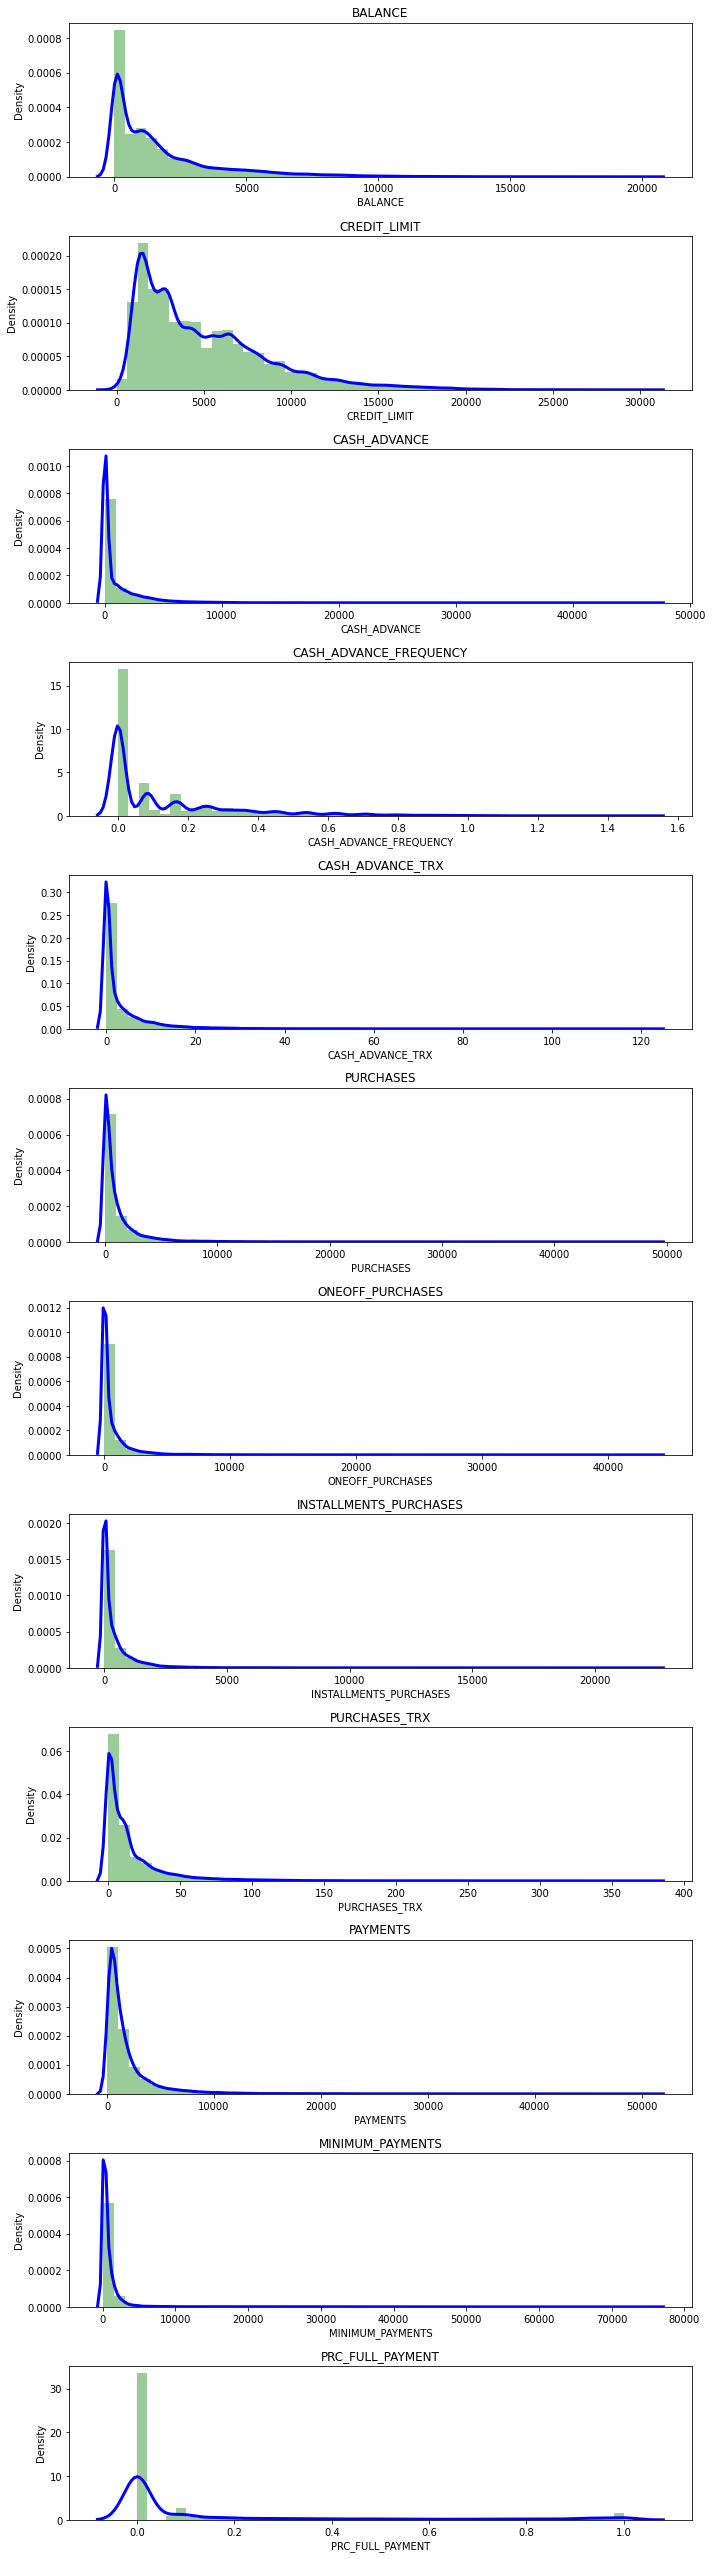

In [11]:
# visualise probability density of all columns
plt.figure(figsize=(10,50))
for i in range(len(df.columns)):
  plt.subplot(17,1,i+1)
  sns.distplot(df[df.columns[i]],kde_kws={"color":"b","lw":3,"label":"KDE"},hist_kws={"color":"g"})
  plt.title(df.columns[i])
plt.tight_layout()
# This is to ignore warning
import warnings
warnings.filterwarnings('ignore')

In [12]:
# find outlier in all columns
for i in df.select_dtypes(include=['float64','int64']).columns:
  max_thresold = df[i].quantile(0.95)
  min_thresold = df[i].quantile(0.05)
  df_no_outlier = df[(df[i] < max_thresold) & (df[i] > min_thresold)].shape
  print(" outlier in ",i,"is" ,int(((df.shape[0]-df_no_outlier[0])/df.shape[0])*100),"%")

 outlier in  BALANCE is 10 %
 outlier in  CREDIT_LIMIT is 10 %
 outlier in  CASH_ADVANCE is 55 %
 outlier in  CASH_ADVANCE_FREQUENCY is 55 %
 outlier in  CASH_ADVANCE_TRX is 55 %
 outlier in  PURCHASES is 28 %
 outlier in  ONEOFF_PURCHASES is 49 %
 outlier in  INSTALLMENTS_PURCHASES is 49 %
 outlier in  PURCHASES_TRX is 28 %
 outlier in  PAYMENTS is 10 %
 outlier in  MINIMUM_PAYMENTS is 10 %
 outlier in  PRC_FULL_PAYMENT is 72 %


In [13]:
# remove outliers from columns having nearly 10% outlier
max_thresold_BALANCE = df["BALANCE"].quantile(0.95)
min_thresold_BALANCE = df["BALANCE"].quantile(0.05)
max_thresold_CREDIT_LIMIT = df["CREDIT_LIMIT"].quantile(0.95)
min_thresold_CREDIT_LIMIT = df["CREDIT_LIMIT"].quantile(0.05)
max_thresold_PAYMENTS = df["PAYMENTS"].quantile(0.95)
min_thresold_PAYMENTS = df["PAYMENTS"].quantile(0.05)
df_no_outlier = df[(df["CREDIT_LIMIT"] < max_thresold_CREDIT_LIMIT) & (df["CREDIT_LIMIT"] > min_thresold_CREDIT_LIMIT) & (df["BALANCE"] < max_thresold_BALANCE) & (df["BALANCE"] > min_thresold_BALANCE) &  (df["PAYMENTS"] < max_thresold_PAYMENTS) & (df["PAYMENTS"] > min_thresold_PAYMENTS)]

In [14]:
df_no_outlier.head()

,BALANCE,CREDIT_LIMIT,CASH_ADVANCE,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,PURCHASES_TRX,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT
0,2914.245349,6510.0,5863.08039,0.2325,3.76,0.0000,0.00000,0.0,0.000,3774.789989,1007.999804,0.214444
1,2582.479072,7950.0,0.00000,0.0000,0.00,734.5115,819.56020,0.0,11.400,665.611414,589.647700,0.000000
2,2270.585464,7762.5,0.00000,0.0000,0.00,719.0481,746.10905,0.0,10.920,653.170079,570.829156,0.000000
5,846.334337,1260.0,0.00000,0.0000,0.00,17.4400,16.80000,0.0,0.965,617.284634,227.655850,0.000000
6,1096.120591,6440.0,0.00000,0.0000,0.00,930.4092,638.33785,188.0,4.700,664.188818,290.125970,0.000000


<Axes: >

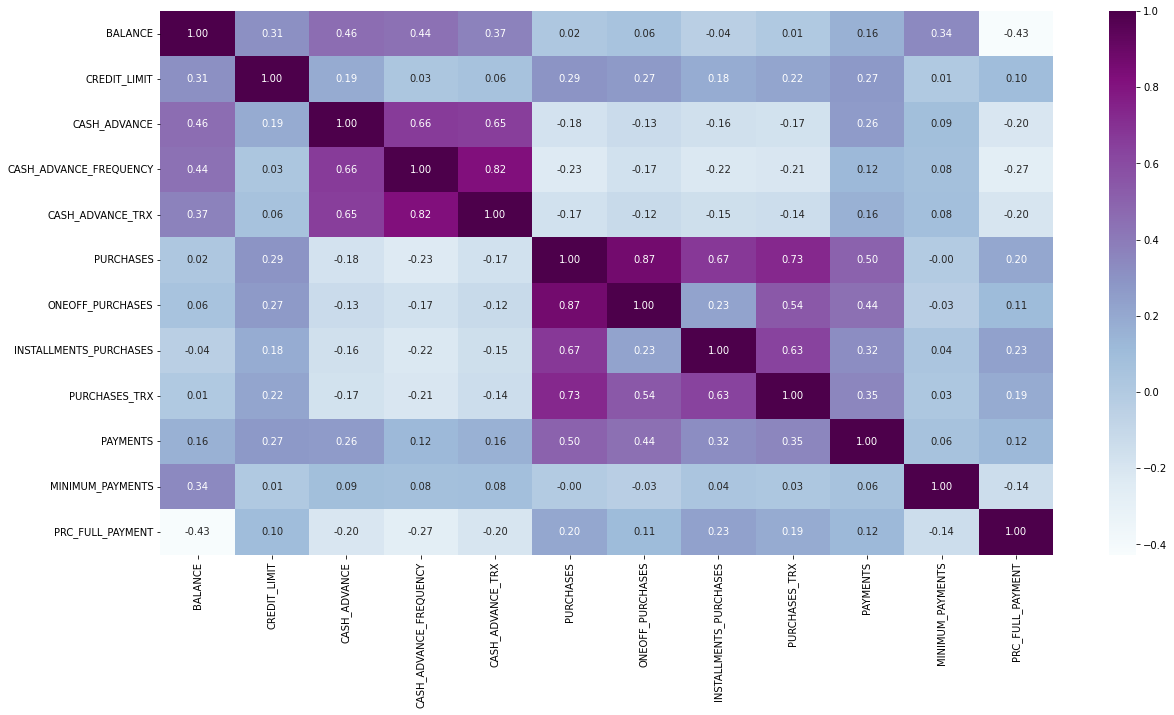

In [15]:
# correlation matrix of DataFrame
plt.figure(figsize=(20,10))
corn=df_no_outlier.corr()
sns.heatmap(corn,annot=True,cmap="BuPu",fmt='.2f')

In [16]:
# scale the DataFrame
scalar=StandardScaler()
scaled_df = scalar.fit_transform(df_no_outlier)

### PCA

In [17]:
# convert the DataFrame into 2D DataFrame for visualization
pca = PCA(n_components=2)
principal_comp = pca.fit_transform(scaled_df)
pca_df = pd.DataFrame(data=principal_comp,columns=["pca1","pca2"])

In [18]:
pca_df.head()

,pca1,pca2
0,-1.693472,2.302162
1,0.122506,-0.243443
2,0.100266,-0.375116
3,-0.777715,-1.835787
4,0.180413,-0.847404


In [19]:
scaled_df_original = scaled_df.copy()
scaled_df = scaled_df[:20000]

In [20]:
pca_df_original = pca_df.copy()
pca_df = pca_df.head(20000)

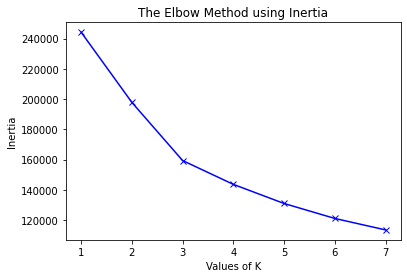

In [21]:
# find 'k' value by Elbow Method
inertia = []
range_val = range(1,8)
for i in range_val:
  kmean = KMeans(n_clusters=i)
  kmean.fit_predict(pd.DataFrame(scaled_df))
  inertia.append(kmean.inertia_)
plt.plot(range_val,inertia,'bx-')
plt.xlabel('Values of K') 
plt.ylabel('Inertia') 
plt.title('The Elbow Method using Inertia') 
plt.show()

# KMeans 

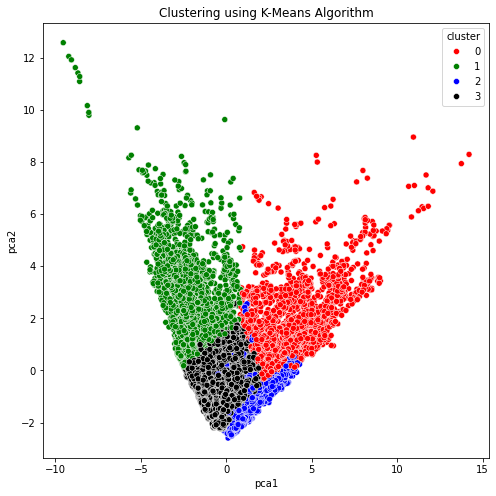

In [22]:
# apply kmeans algorithm
kmeans_model=KMeans(4)
kmeans_model.fit_predict(scaled_df)
pca_df_kmeans= pd.concat([pca_df,pd.DataFrame({'cluster':kmeans_model.labels_})],axis=1)


# visualize the clustered dataframe
# Scatter Plot
plt.figure(figsize=(8,8))
#palette=['dodgerblue','red','green','blue','black','pink','gray','purple','coolwarm']
ax=sns.scatterplot(x="pca1",y="pca2",hue="cluster",data=pca_df_kmeans,palette=['red','green','blue','black'])
plt.title("Clustering using K-Means Algorithm")
plt.show()

# Gaussian Mixture Model

In [23]:
# GaussianMixture Model based clustering
def train_GaussianMixture(k,X):
  GaussianMixture_model = GaussianMixture(n_components=k)
  y_pred = GaussianMixture_model.fit_predict(X)
  print("GaussianMixture Model based Clustering : clusters : ",k ," silhouette_score : ",silhouette_score(X,y_pred) )

In [24]:
# GaussianMixture Model based clustering
clusters=[3,4,5,6]
for i in clusters:
  train_GaussianMixture(i,scaled_df)

GaussianMixture Model based Clustering : clusters :  3  silhouette_score :  0.07401567811857622
GaussianMixture Model based Clustering : clusters :  4  silhouette_score :  0.05086699550765077
GaussianMixture Model based Clustering : clusters :  5  silhouette_score :  0.05572811152595027
GaussianMixture Model based Clustering : clusters :  6  silhouette_score :  0.009962888809046418


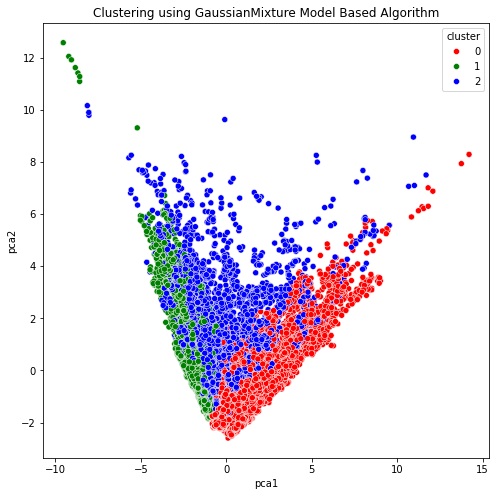

In [25]:
GaussianMixture_model = GaussianMixture(n_components=3)
y_pred = GaussianMixture_model.fit_predict(scaled_df)
pca_df_gmm= pd.concat([pca_df,pd.DataFrame({'cluster':y_pred})],axis=1)

# Scatter Plot
plt.figure(figsize=(8,8))
ax=sns.scatterplot(x="pca1",y="pca2",hue="cluster",data=pca_df_gmm,palette=['red','green','blue'])
plt.title("Clustering using GaussianMixture Model Based Algorithm")
plt.show()

# DBSCAN

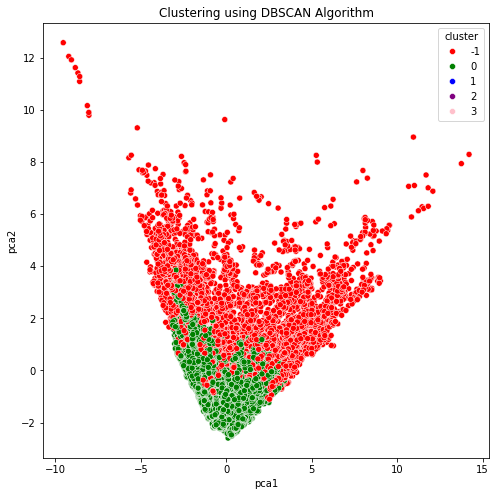

In [26]:
model_dbscan = DBSCAN(eps=1, min_samples=18)
y_pred = model_dbscan.fit_predict(scaled_df)
pca_df_dbscan= pd.concat([pca_df,pd.DataFrame({'cluster':model_dbscan.labels_})],axis=1)

# Scatter Plot
plt.figure(figsize=(8,8))
ax=sns.scatterplot(x="pca1",y="pca2",hue="cluster",data=pca_df_dbscan,palette=['red','green','blue','purple','pink'])
plt.title("Clustering using DBSCAN Algorithm")
plt.show()

In [27]:
# find all cluster centers
cluster_centers = pd.DataFrame(data=kmeans_model.cluster_centers_,columns=[df.columns])
# inverse transfor the data
cluster_centers = scalar.inverse_transform(cluster_centers)
cluster_centers = pd.DataFrame(data=cluster_centers,columns=[df.columns])
cluster_centers

,BALANCE,CREDIT_LIMIT,CASH_ADVANCE,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,PURCHASES_TRX,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT
0,1834.546472,6563.600612,310.689035,0.046848,0.922916,3771.658216,2413.234630,1364.136617,52.491240,3163.197799,715.614458,0.189815
1,3289.244389,5838.119547,3227.241024,0.440682,11.670656,383.370926,245.034428,137.972173,6.527291,2058.666184,1542.629165,0.023601
2,130.151632,5297.068597,40.917303,0.010136,0.186009,1107.671723,455.170072,653.928910,18.960648,1301.493595,187.300137,0.719051
3,1287.376108,3585.284566,402.948745,0.086275,1.483043,502.036281,312.649130,189.344775,8.409383,978.349984,701.139515,0.029472


In [30]:
# create a column as "cluster" & store the respective cluster name that they belongs to
cluster_df = pd.concat([df,pd.DataFrame({'cluster':kmeans_model.labels_})],axis=1)
cluster_df.head()

,BALANCE,CREDIT_LIMIT,CASH_ADVANCE,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,PURCHASES_TRX,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,cluster
0,2914.245349,6510.0,5863.080390,0.232500,3.76,0.0000,0.00000,0.0,0.000,3774.789989,1007.999804,0.214444,1.0
1,2582.479072,7950.0,0.000000,0.000000,0.00,734.5115,819.56020,0.0,11.400,665.611414,589.647700,0.000000,3.0
2,2270.585464,7762.5,0.000000,0.000000,0.00,719.0481,746.10905,0.0,10.920,653.170079,570.829156,0.000000,3.0
3,1766.670775,7125.0,187.267095,0.088333,0.94,1379.0800,1603.93000,0.0,0.965,0.000000,0.000000,0.000000,3.0
4,1783.337480,7875.0,198.585436,0.078333,1.05,1633.9100,1588.94000,0.0,1.060,0.000000,0.000000,0.000000,3.0


In [31]:
cluster_1_df = creditcard_cluster_df[cluster_df["cluster"]==0]
cluster_1_df.head()

,BALANCE,CREDIT_LIMIT,CASH_ADVANCE,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,PURCHASES_TRX,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,cluster
19,3010.319371,6580.0,6765.092757,0.2700,4.36,0.0000,0.0000,0.0000,0.00,3815.820315,1109.872125,0.204444,0.0
43,1004.645772,7950.0,0.000000,0.0000,0.00,2308.9644,398.9620,1563.3527,24.18,1597.935235,238.581087,0.080416,0.0
44,3314.553776,6755.0,6056.368754,0.2675,4.36,0.0000,0.0000,0.0000,0.00,3856.850641,1136.680630,0.206666,0.0
45,2669.809282,7125.0,0.000000,0.0000,0.00,842.7553,719.0481,0.0000,12.60,578.522070,583.374852,0.000000,0.0
46,2258.561046,3210.0,2617.218221,0.2725,3.21,0.0000,0.0000,0.0000,0.00,356.696851,342.687464,0.000000,0.0


In [32]:
cluster_2_df = creditcard_cluster_df[cluster_df["cluster"]==1]
cluster_2_df.head()

,BALANCE,CREDIT_LIMIT,CASH_ADVANCE,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,PURCHASES_TRX,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,cluster
0,2914.245349,6510.0,5863.080390,0.232500,3.760,0.0000,0.0000,0.0000,0.000,3774.789989,1007.999804,0.214444,1.0
9,37.219682,920.0,0.000000,0.000000,0.000,89.6760,0.0000,98.7390,1.860,194.739011,150.670570,0.000000,1.0
10,595.897766,14445.0,0.000000,0.000000,0.000,7658.2908,6722.7615,626.4258,59.520,6862.659474,204.998200,1.000000,1.0
12,1783.337480,6975.0,189.324976,0.088333,1.035,1424.0500,1394.0700,0.0000,1.035,0.000000,0.000000,0.000000,1.0
25,1228.468692,1092.0,0.000000,0.000000,0.000,984.5284,0.0000,874.1140,11.280,1045.385472,2096.653343,0.000000,1.0


In [33]:
cluster_3_df = creditcard_cluster_df[cluster_df["cluster"]==2]
cluster_3_df.head()

,BALANCE,CREDIT_LIMIT,CASH_ADVANCE,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,PURCHASES_TRX,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,cluster
33,20.298411,6555.0,0.000000,0.000000,0.000,94.000,0.0000,91.000,4.65,149.514029,165.273397,0.00000,2.0
89,1313.116394,1635.0,1377.875996,0.080416,0.965,0.000,0.0000,0.000,0.00,355.596573,332.601532,0.00000,2.0
129,623.212360,6370.0,1356.401909,0.116250,2.760,0.000,0.0000,0.000,0.00,878.591956,128.294706,0.25875,2.0
152,6902.514119,9660.0,2370.313975,0.875000,15.440,410.273,222.9595,169.725,7.36,1521.375930,1533.431751,0.00000,2.0
153,5686.190702,5520.0,1004.562029,0.306666,4.240,242.740,0.0000,247.320,5.52,2216.084874,1989.777478,0.00000,2.0


In [34]:
cluster_4_df = creditcard_cluster_df[cluster_df["cluster"] == 3]
cluster_4_df.head()

,BALANCE,CREDIT_LIMIT,CASH_ADVANCE,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,PURCHASES_TRX,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,cluster
1,2582.479072,7950.0,0.000000,0.000000,0.00,734.5115,819.56020,0.0,11.400,665.611414,589.647700,0.0,3.0
2,2270.585464,7762.5,0.000000,0.000000,0.00,719.0481,746.10905,0.0,10.920,653.170079,570.829156,0.0,3.0
3,1766.670775,7125.0,187.267095,0.088333,0.94,1379.0800,1603.93000,0.0,0.965,0.000000,0.000000,0.0,3.0
4,1783.337480,7875.0,198.585436,0.078333,1.05,1633.9100,1588.94000,0.0,1.060,0.000000,0.000000,0.0,3.0
5,846.334337,1260.0,0.000000,0.000000,0.00,17.4400,16.80000,0.0,0.965,617.284634,227.655850,0.0,3.0
